# Test score fusion and calibration for Speaker Verification (SV)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
os.chdir('../..')
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

In [7]:
import torch

import matplotlib
matplotlib.rc('pdf', fonttype=42)

from notebooks.notebooks_utils import (
    load_models,
    evaluate_models,
    create_metrics_df
)

from sv_visualization import scores_distribution
from ScoreCalibration import ScoreCalibration

from sslsv.evaluations.CosineSVEvaluation import CosineSVEvaluation, CosineSVEvaluationTaskConfig
from sslsv.evaluations.CosineSVEvaluation import SpeakerVerificationEvaluation, SpeakerVerificationEvaluationTaskConfig

In [3]:
models = load_models(
    [
        './exps/old/vox2_ddp_sntxent_s=30_m=0/config.yml',
        './exps/old/vox2_ddp_sntxent_s=30_m=0.1/config.yml'
    ],
    override_names={
        'exps/old/vox2_ddp_sntxent_s=30_m=0'   : 'simclr',
        'exps/old/vox2_ddp_sntxent_s=30_m=0.1' : 'simclr_am'
    }
)

In [4]:
evals = evaluate_models(models, CosineSVEvaluation, CosineSVEvaluationTaskConfig(), return_evals=True)
create_metrics_df(models)

Extracting test embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:22<00:00,  3.31it/s]


,voxceleb1_test_O/eer,voxceleb1_test_O/mindcf
Model,,
simclr_am,7.8473,0.6168
simclr,8.4056,0.6235


In [5]:
class FusedAndCalibratedSVEvaluation(SpeakerVerificationEvaluation):
    
    def __init__(self, evaluations, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.evaluations = evaluations
        self.sc = ScoreCalibration(evaluations)

    def _prepare_evaluation(self):
        self.sc.train()
    
    def _get_sv_score(self, a, b):
        scores = [evaluation._get_sv_score(a, b) for evaluation in self.evaluations]
        score = self.sc.predict(torch.tensor(scores).unsqueeze(0))
        return score.detach().item()

In [8]:
evaluation = FusedAndCalibratedSVEvaluation(
    evaluations=evals,
    model=None,
    config=evals[0].config,
    task_config=SpeakerVerificationEvaluationTaskConfig()
)

models['final'] = {
    'metrics': evaluation.evaluate(),
    'scores': evaluation.scores,
    'targets': evaluation.targets
}

create_metrics_df(models)

,voxceleb1_test_O/eer,voxceleb1_test_O/mindcf
Model,,
final,7.8101,0.6061
simclr_am,7.8473,0.6168
simclr,8.4056,0.6235


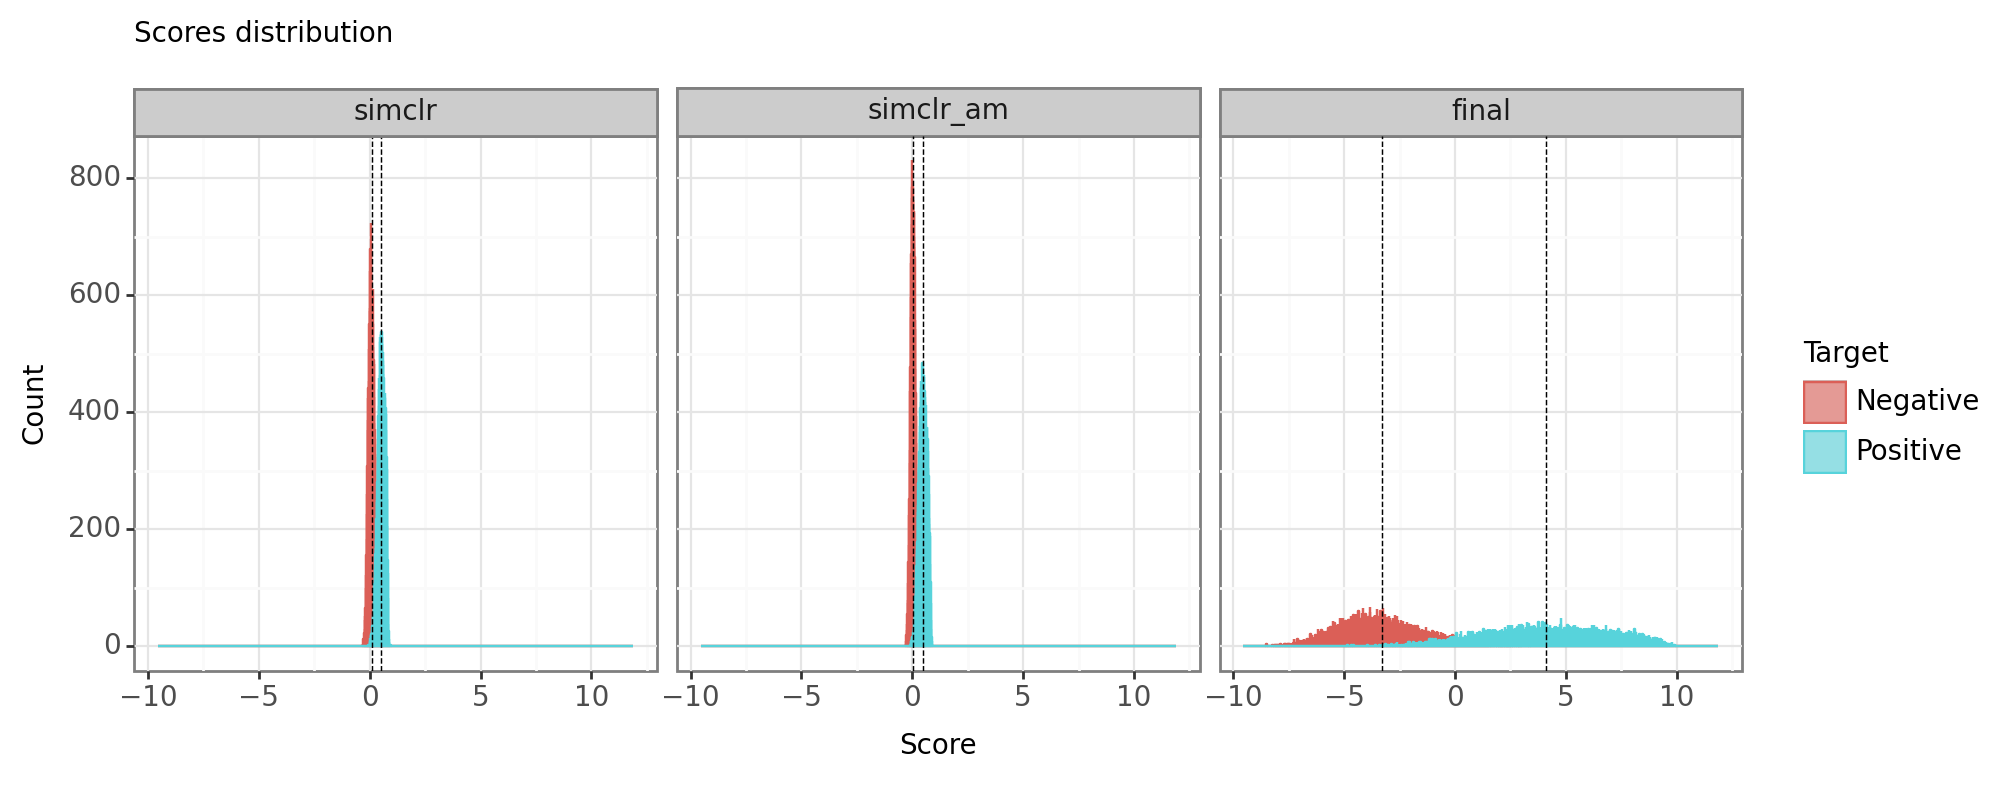

<Figure Size: (1000 x 400)>

In [9]:
scores_distribution(models, use_angle=False)